Using device: cuda
DeepConvNet_A1(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Linear(in_features=256, out_features=100, bias=True)
)
[Epoch 1/100] Train Loss: 

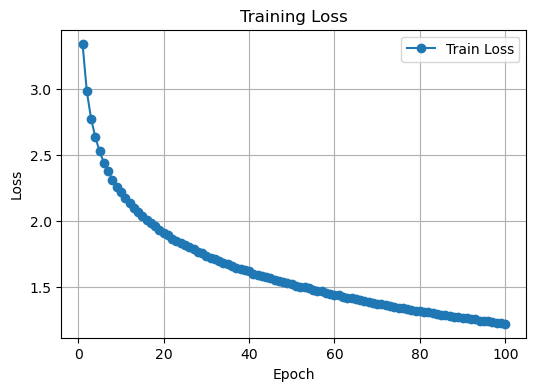

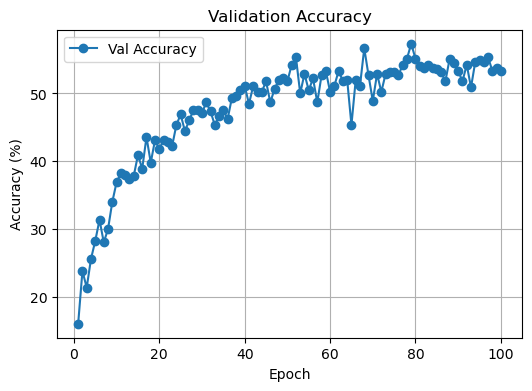


=== Final Results ===
| Method                   |   #Param (M) |   MAdds (M) |   Top-1 (%) |
|:-------------------------|-------------:|------------:|------------:|
| DeepConvNet_HalfChannels |         0.19 |      105.58 |       54.67 |

Training history saved to 'metrics_history.csv' and final results saved to 'final_results.csv'.


In [4]:
# -------------------------------
# 1. 匯入必要套件
# -------------------------------
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from thop import profile

# -------------------------------
# 2. 設定運算裝置 (GPU / CPU)
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------
# 3. 定義讀取 txt 檔案的函式 (讀取圖片路徑與標籤)
# -------------------------------
def load_dataset(txt_file):
    samples = []
    with open(txt_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                img_path, label = parts
                samples.append((img_path, int(label)))
    return samples

# -------------------------------
# 4. 自訂義 Dataset
# -------------------------------
class ImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        img_path, label = self.samples[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# -------------------------------
# 5. 設定影像前處理 (transforms)
# -------------------------------
transform_train = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
transform_val_test = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -------------------------------
# 6. 讀取 train.txt, val.txt, test.txt
# -------------------------------
train_samples = load_dataset('train.txt')
val_samples   = load_dataset('val.txt')
test_samples  = load_dataset('test.txt')

batch_size = 32
train_loader = DataLoader(ImageDataset(train_samples, transform_train),
                          batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(ImageDataset(val_samples,   transform_val_test),
                          batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(ImageDataset(test_samples,  transform_val_test),
                          batch_size=batch_size, shuffle=False, num_workers=2)

# -------------------------------
# 7. 定義修改後的卷積模型架構 (DeepConvNet) — 通道數減半
# -------------------------------
class DeepConvNet_A1(nn.Module):
    def __init__(self, num_classes=100):
        super(DeepConvNet_A1, self).__init__()
        # 第一層：3→32，84→42
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        # 第二層：32→64，42→21
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        # 第三層：64→256，21→1
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        # 全連接層：256 → num_classes
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = DeepConvNet_A1(num_classes=100).to(device)
print(model)

# -------------------------------
# 8. 定義損失函式與優化器
# -------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -------------------------------
# 9. 定義訓練與評估函式
# -------------------------------
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total  += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total

# -------------------------------
# 10. 主訓練迴圈，並記錄 loss 與 val accuracy
# -------------------------------
num_epochs = 100
loss_history    = []
val_acc_history = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_acc    = evaluate(model, val_loader, device)
    loss_history.append(train_loss)
    val_acc_history.append(val_acc)
    print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

# -------------------------------
# 11. 在測試集上評估
# -------------------------------
test_acc = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# -------------------------------
# 12. 計算 FLOPs 與參數量
# -------------------------------
dummy_input = torch.randn(1, 3, 84, 84).to(device)
flops, params = profile(model, inputs=(dummy_input,), verbose=False)
print(f"FLOPs: {flops:,}  Params: {params:,}")

# -------------------------------
# 13. 繪製 Loss & Val Accuracy 曲線
# -------------------------------
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs+1), loss_history, marker='o', label='Train Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training Loss')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs+1), [x*100 for x in val_acc_history],
         marker='o', label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Validation Accuracy')
plt.legend(); plt.grid(True); plt.show()

# -------------------------------
# 14. 存成 CSV：最終結果與訓練歷史
# -------------------------------
method_name = "DeepConvNet_HalfChannels"
madds       = flops / 1e6  # 百萬次操作
params_m    = params / 1e6  # 百萬參數
top1        = test_acc * 100

final_table = pd.DataFrame({
    "Method":    [method_name],
    "#Param (M)": [f"{params_m:.2f}"],
    "MAdds (M)":  [f"{madds:.2f}"],
    "Top-1 (%)":  [f"{top1:.2f}"]
})
print("\n=== Final Results ===")
print(final_table.to_markdown(index=False))
final_table.to_csv("final_results.csv", index=False)

history_df = pd.DataFrame({
    "Epoch":        list(range(1, num_epochs+1)),
    "Train_Loss":   loss_history,
    "Val_Acc (%)": [acc*100 for acc in val_acc_history]
})
history_df.to_csv("metrics_history.csv", index=False)
print("\nTraining history saved to 'metrics_history.csv' and final results saved to 'final_results.csv'.")
